In [1]:
using Random
using Distributions
using FFTW
using LinearAlgebra 
using Arpack 
using Plots

In [2]:
#L=100; #system size
W=[]; #disorder strenght
sigma=0.2; 
theta=0.5;  #the twist
Nreal=200;  #number of samples

seeds=rand(1:100000,Nreal); #random seeds

#dis = Normal(-0.1, W);
#Normal{Float64}(μ=0.16, σ=W)

#td = truncated(dis, 0.0, Inf)
#Truncated(Normal{Float64}(μ=0.0, σ=W), range=(0.0, Inf))

tk(n,sig,ll,th)=-sign(cos(2.0*pi*n/ll+th/ll))*abs(cos(2.0*pi*n/ll+th/ll))^sig; #k-space Hamiltonian


In [3]:
#L=100; #system size
IPR=[float,Nreal,0];
IPRa=[];     #average participation ratio 
IPRm=[];     #array of maximum IPRs for different system sizes
IPRmin=[];   #array of indeces of maximum IPRs for different system sizes
w=0.0;
ws=0.05; #increament of disorder strength at each loop 
wm=1.0;  #maximum disorder strength

IPRA=[float,Int(floor(wm/ws)),0];


for n in 1:Int(floor(wm/ws))   #loop for creating array of different disorder strengths
    w=w+n*ws
    W=append!(W,w)   
end 

for m in 1:10 #loop for different system sizes 
  
  L=100*m;

  for dn in 1:Int(floor(wm/ws))    #loop for different disorder strengths

    dis=Normal(-0.1, W[dn]);

    En=[];
    ipr=[];
    Evec=[float,L,0];

    for ireal in 1:Nreal 
        Random.seed!(seeds[ireal]) #setting the seed
        Vx=rand(dis,L);    #generating random potential according to normal distribution
        Vk=fft(Vx);        #Fourier transform of random potential
        Vk=fftshift(Vk);   #moving the zero potential to the center of the spectrum


        Ham=zeros(Complex{Float64},L,L);          #initializing the Hamiltonian matrix with zeros
        vecs=zeros(Complex{Float64},L,L);         #initializaing the eigenvectors with zeros
        for i in 1:L                              #compute k-space Hamiltonian for L allowed k values
            Ham[i,i]=tk(i,sigma,L,theta);  
           for j in i+1:L       
                 Ham[j,i] = Vk[j-i] ; 
                 Ham[i,j] = conj(Vk[j-i]);
            end    
        end


        en0, evec0=eigs(Ham,nev=1,which=:SM);
        evec1=fft(evec0);
        ipr0=sum((abs.(evec1).^2).^2)/(sum(abs.(evec1).^2))^2;
        En=append!(En,en0);
        ipr=append!(ipr,ipr0);
        if ireal==1
            Evec=evec1
            else
                Evec=hcat(Evec,evec1);
        end

    end ## end loop over ireal

      #creating array of inverse participation ratios, each column is IPR of each increament of disorder strength
      if dn==1
         IPR=ipr 
         else
             IPR=hcat(IPR,ipr);
      end  

      IPRa0=sum(ipr)/Nreal;          #average inverse participation ratio at each step 
      IPRa=append!(IPRa,IPRa0);       #creating array of average inverse participation ratios  


  end           ##end loop over dn

  IPRmx=maximum(IPRa);
  IPRm=append!(IPRm,IPRmx);
  IPRmin=append!(IPRmin,argmax(IPRa));

  if m==1
    IPRA=IPRa;
    else
      IPRA=hcat(IPRA,IPRa);
  end

  empty!(IPRa);    #clear the array of average IPR for different disorder strengths 

end     ## end loop over m 
  

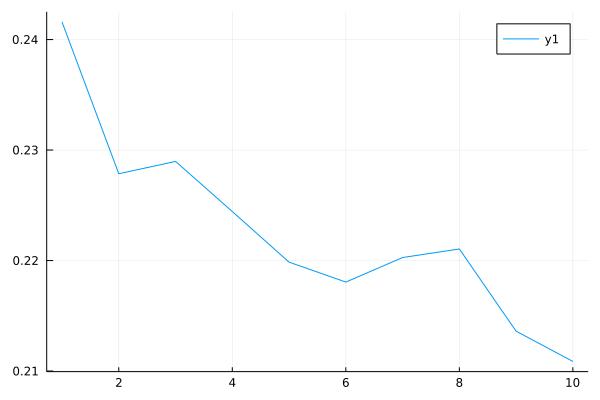

In [4]:
plot(IPRm)